# Beam and Point Source Optimization <a name="optimization"></a>

We will setup a joint optimization of an radio telescope antenna primary beam response alongside a catalogue of radio point sources.

Author: Nick Kern


Last edited: July 2025
<br>
Created: May 2025

## Setting up the problem
We will use a restricted set of frequencies, and a simple beam model, just as a demonstration. More complex beam model representations exist, as demonstrated in the initial BayesLIM paper.
To setup a mock observation, we will use a small HERA-like redundant array, and we will assume that all antennas share the same beam model. Furthermore, we will assume we know the locations of the radio point sources, but will solve for the fluxes.

First we will create the observing frequencies, times, and the array layout.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import bayeslim as ba
import copy

torch.set_default_dtype(torch.float64)

In [2]:
print("numpy version:", np.__version__)
print("BayesLIM version:", ba.__version__)
print("pytorch version:", torch.__version__)

numpy version: 1.26.3
BayesLIM version: 0.0.1
pytorch version: 2.2.1


In [3]:
# setup observing frequencies: 20 channels
freqs = torch.linspace(120e6, 130e6, 20)
Nfreqs = len(freqs)

# setup observing times: 50 times
times = torch.linspace(2458148.15, 2458148.25, 50)

### Array Layout and Telescope Model

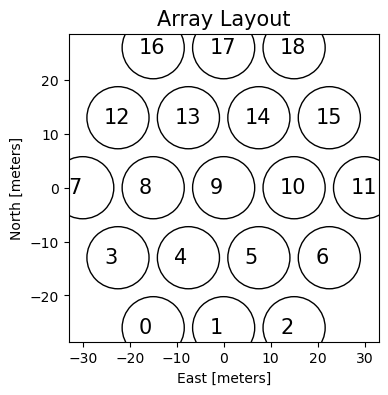

In [4]:
# setup telescope array: antenna numbers and antenna vectors in [X,Y,Z] (meters)
ants, antvecs = ba.utils._make_hex(3)

plt.figure(figsize=(4,4))
plt.scatter(*antvecs[:, :2].T, s=2000, ec='k', fc='none')
for ant, antvec in zip(ants, antvecs):
    plt.text(antvec[0]-3, antvec[1]-1, ant, fontsize=15)
plt.title('Array Layout', fontsize=15)
plt.xlabel('East [meters]'); plt.ylabel('North [meters]');

In [5]:
# create an Array object
antpos_dict = dict(zip(ants, antvecs))
array = ba.telescope_model.ArrayModel(antpos_dict, freqs=freqs)

/Users/nkern/anaconda3/envs/py311/lib/python3.11/site-packages/bayeslim/utils.py:2220: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/torch/csrc/utils/tensor_new.cpp:278.)
  self.antvecs = torch.as_tensor(antvecs)


In [6]:
# create the telescope: (longitude, latitude) in degrees
telescope = ba.telescope_model.TelescopeModel((21.42827, -30.72148))

In [7]:
# given the telescope model, print out the LSTs of the observing times
lsts = ba.telescope_model.JD2LST(times, telescope.location[0])
# get lsts from radians -> hour angle
lsts = np.unwrap(lsts) * 12 / np.pi
print("LST range {:.2f} -- {:.2f} hours".format(lsts[0], lsts[-1]))

LST range 1.62 -- 4.02 hours


Next we will create the beam and sky model. The beam model will be a Gaussian with two parameters, the width along the East-West direction and the width along the North-South direction, which will be a frequency-dependent parameter. The units of the width are in the dimensionless $l$ and $m$ cosines of the sky.

### Beam Model

In [8]:
# make the beam response function
R = ba.beam_model.GaussResponse()

# the beam parameter should have shape: (Npol, Nvec, Nmodel, Nfreqs, 2)
# where the last dimension is (EW, NS) respectively
beam_params = torch.ones(1, 1, 1, Nfreqs, 2)
beam_params[..., :, 0] = torch.linspace(.25, .30, Nfreqs) # east-west
beam_params[..., :, 1] = torch.linspace(.20, .25, Nfreqs) # north-south

# make the beam model: parameter=True makes the beam_params differentiable in the graph
# we have to specify a feed polarization, but it is arbitrary
beam_model = ba.beam_model.PixelBeam(beam_params.clone(), freqs, R=R, parameter=True, name='beam', pol='e')

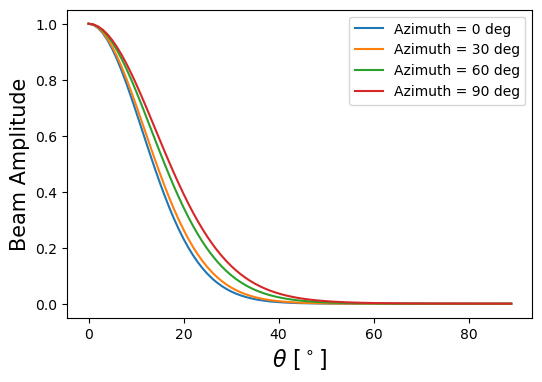

In [9]:
plt.figure(figsize=(6, 4))
plt.xlabel(r'$\theta\ [^\circ]$', fontsize=16)
plt.ylabel('Beam Amplitude', fontsize=15)

# test its output by plotting a slice along the beam
for _az in [0, 30, 60, 90]:
    zen = torch.linspace(0, 89, 90) # zenith angles [deg]
    az = torch.ones_like(zen) * _az # azimuth angles [deg]
    with torch.no_grad():
        # we enter this context b/c we don't want the output to be differentiable
        # because we aren't optimizing, just inspecting the output
        beam_output, _, _, _ = beam_model.gen_beam(zen, az)

    # beam_output has shape (Npol, Nvec, Nmodel, Nfreqs, Nzen)
    plt.plot(zen, beam_output[0,0,0,0], label=f'Azimuth = {_az:.0f} deg')

plt.legend();

To set a prior on the beam model, we will use a Gaussian prior that enables 10% variation in the beam width.

In [10]:
# use the current value as the prior mean, and 10% of current value as prior width
mean = beam_model.params.detach()       
std = beam_model.params.detach() * 0.1

# we assume this is a diagonal covariance
beam_prior = ba.optim.LogGaussPrior(mean, std**2, diag_cov=True)
beam_model.set_priors(beam_prior)

### Prior predictive check


Let's run a prior predictive check on the adopted prior model. This means drawing from the prior and forward modeling the component to see what it looks like in configuration space.

In [11]:
# draw 50 random vectors scaled by the beam_std
torch.manual_seed(-1)
rands = torch.randn(50, *beam_model.params.shape) * std

In [12]:
# push through the beam response function manually
prior_draws = []
for r in rands:
    with torch.no_grad():
        prior_draws.append(beam_model.R(beam_model.params + r, zen, az, freqs))
prior_draws = torch.stack(prior_draws)
print(prior_draws.shape)

torch.Size([50, 1, 1, 1, 20, 90])


Now we have 50 realizations of the beam slices given our prior model. Let's plot them.

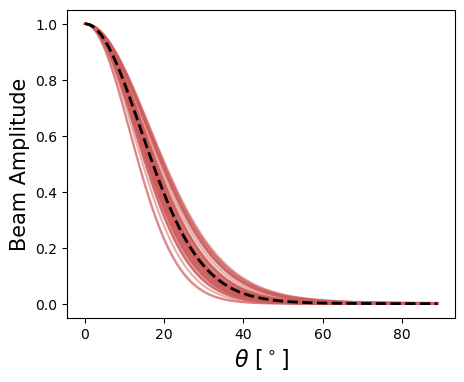

In [13]:
plt.figure(figsize=(5, 4))
plt.plot(zen, prior_draws[:, 0, 0, 0, 0, :].T, c='indianred', alpha=.5);
plt.plot(zen, beam_output[0,0,0,0], c='k', lw=2, ls='--')
plt.xlabel(r'$\theta\ [^\circ]$', fontsize=16)
plt.ylabel('Beam Amplitude', fontsize=15);

This seems like a reasonable prior model, given we think we know the primary beam response to roughly 10% or better in some cases.

### Point Source Model

We will create a random collection of point sources within the observing mask given the observing times and width of the primary beam. They will follow a powerlaw model, and the parameters will be the log-flux amplitude (excluding the spectral index).

In [14]:
# populate 1000 point sources randomly on the sky across 5 hours of RA
# note: this quasi-uniform distribution technically assumes a flat-sky approximation
torch.manual_seed(6)
ra = torch.rand(1000) * 5 * 15        # in degrees
dec = (torch.rand(1000)-.5) * 80 -30.72 # in degrees
fluxes = torch.randn(1000)              # log-normal fluxes
spix = torch.randn(1000) * .1 - 2.2     # gaussian spix centered at -2.2

In [15]:
# generate a response function for the point sources in the form of a log-powerlaw
# set the powerlaw anchor frequency (f0) as the zeroth freq channel
R = ba.sky_model.PointSkyResponse(freqs, freq_mode='powerlaw', log=True, f0=freqs[:1])

# sky_params.shape = (Nstokes, 1, 2, Nsources)
sky_params = torch.stack([fluxes, spix])[None, None, :, :]
sky_angs = torch.stack([ra, dec])
sky_model = ba.sky_model.PointSky(sky_params.clone(), sky_angs, R=R, name='sky', parameter=True)

In [16]:
# have a look at the output, which comes as a MapData() object
# which returns point source fluxes
with torch.no_grad():
    sky = sky_model()
print("MapData.data.shape = (Nstokes, 1, Nfreqs, Nsources) = {}".format(sky.data.shape))

MapData.data.shape = (Nstokes, 1, Nfreqs, Nsources) = torch.Size([1, 1, 20, 1000])


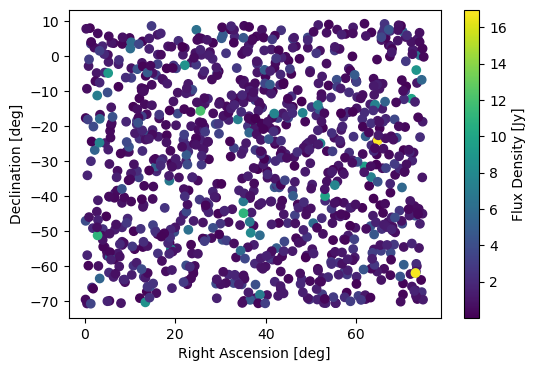

In [17]:
plt.figure(figsize=(6, 4))
plt.scatter(*sky_angs, c=sky.data[0,0,0])
plt.colorbar(label='Flux Density [Jy]')
plt.xlabel('Right Ascension [deg]'); plt.ylabel('Declination [deg]');

Now let's set a prior. The prior will go on the log-fluxes, and it will also be set at 10% of the initial flux amplitude, which is consistent with point source catalogues of the low-frequency radio sky.

In [18]:
# set a 10% normal prior on the log-fluxes
# note that we use an indexing to select out just
# the fluxes, such that we are not setting a prior on the
# spectral indices (which we hold fixed)
mean = sky_model.params.detach()[0, 0, 0]
cov = torch.ones_like(mean) * 0.1**2  # this is a 10% prior on unlogged fluxes
sky_prior = ba.optim.LogGaussPrior(mean, cov, diag_cov=True, index=(0, 0, 0))

sky_model.set_priors(sky_prior)

We know how log-normal priors work fairly well, so we will skip the prior predictive check in this case.

### Setup the RIME model

Next we will create the radio interferometric measurement equation (aka the visibility simulator) model.
The interferometric visibility is given as the sky integral of the sky weighted by the primary beam and the baseline fringe response,

\begin{align}
\large
V_{b} = \int d^2\hat{s}\ I(\hat{s})B(\hat{s})\exp[2\pi i\ b\cdot \hat{s}\ \nu/c]
\end{align}

where $b$ is a baseline vector between two antennas, $I$ is the specific intensity of the sky, and $B$ is the beam response. To setup a BayesLIM `RIME()` model, we have all the ingredients except for the collection of baseline vectors we want to simulate visibilities for. We will leverage the inherent redundancies in the array so that we only need to simulate each unique baseline vector, which reduces the amount of computational overhead.

In [19]:
# get the simulated baseline list
sim_bls = array.get_bls(uniq_bls=True, keep_autos=False)
print("Nbls : {}".format(len(sim_bls)))

Nbls : 30


In [20]:
# instantiate the RIME: make copy of some objects that use a cache
rime = ba.rime_model.RIME(
    sky_model,
    copy.deepcopy(telescope),
    beam_model,
    copy.deepcopy(array),
    sim_bls,
    times,
    freqs
)
print(rime)

RIME(
  (sky): PointSky()
  (beam): PixelBeam()
  (array): ArrayModel()
)


By default we've created this model on the CPU, but we can push this all to the GPU if we want. Note if we push to the GPU, then all downstream tensors will also be on the GPU, which means we need to bring them back to the CPU for visualization purposes.

In [21]:
#device = 'cuda'  # push it to a CUDA gpu
device = 'cpu'    # keep it on the cpu, does nothing if already on the cpu

rime.push(device)
rime.sky.push(device)
rime.beam.push(device)
rime.telescope.push(device)
rime.array.push(device)

### Sanity check

Pass the sky model manually through the beam to look at the beam-weighted sky to ensure our units and sky angles are correct. If they are incorrect, we will get a weird result.

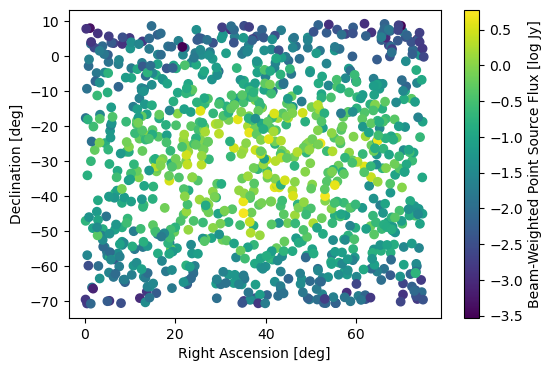

In [22]:
with torch.no_grad():
    # first evalute the sky model to get a MapData object
    sky = sky_model()
    # next pass through the beam manually at a given time
    # doesn't matter which baseline you pick, b/c we are assuming all antennas share 1 beam model
    psky = beam_model.forward(sky, copy.deepcopy(telescope), times[20], sim_bls[0])

# if the plot looks roughly like a Gaussian beam centered in the image, then you're good
plt.figure(figsize=(6, 4))
plt.scatter(*psky['angs'], c=psky['sky'][0,0,0,0].log10())
plt.xlabel('Right Ascension [deg]'); plt.ylabel('Declination [deg]')
plt.colorbar(label='Beam-Weighted Point Source Flux [log Jy]');

Okay, now let's do a dry run of the rime for all baselines, times, and frequencies. By default, this populates some internal caches that make subsequent runs much faster (particularly when running on a GPU).

In [23]:
%%time
# let's do a dry run of the rime model
with torch.no_grad():
    init_vis = rime()

CPU times: user 628 ms, sys: 131 ms, total: 759 ms
Wall time: 196 ms


The output of `rime()` is a `VisData` object which holds the visibilities as `VisData.data` with shape `(Npol, Npol, Nbls, Ntimes, Nfreqs)`.

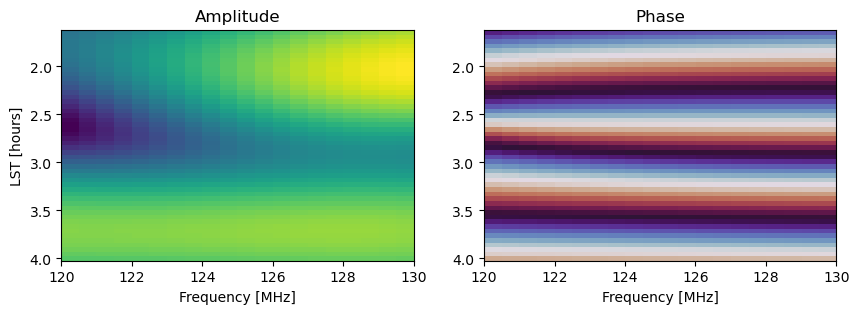

In [24]:
# plot a single visibility amplitude (left) and phase (right)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
bl = (0, 1)
extent = [init_vis.freqs[0]/1e6, init_vis.freqs[-1]/1e6, lsts[-1], lsts[0]]
axes[0].imshow(init_vis[bl].abs(), aspect='auto', extent=extent)
axes[0].set_xlabel('Frequency [MHz]'); axes[0].set_ylabel('LST [hours]'); axes[0].set_title('Amplitude')
axes[1].imshow(init_vis[bl].angle(), aspect='auto', cmap='twilight', extent=extent);
axes[1].set_xlabel('Frequency [MHz]'); axes[1].set_title('Phase');

Now let's run a mock simulation with perturbed parameters that we will aim to solve for.

In [25]:
# get the perturbed parameters
torch.manual_seed(10)
sky_perturb = torch.randn(sky_model.params.shape)[..., :1, :] * .1
beam_perturb = torch.randn(2) / 10

true_sky = rime.sky.params.data + sky_perturb
true_beam = rime.beam.params.data + beam_perturb

init_sky = rime.sky.params.data.clone()
init_beam = rime.beam.params.data.clone()

In [26]:
# now re-do the visibility simulation with the perturbed parameters
rime.sky.params.data += sky_perturb
rime.beam.params.data += beam_perturb

In [27]:
%%time
# simulate a raw dataset
with torch.no_grad():
    raw_vis = rime()

CPU times: user 539 ms, sys: 95.3 ms, total: 635 ms
Wall time: 99.3 ms


In [28]:
# now undo the perturbation to get back to our starting point
rime.sky.params.data -= sky_perturb
rime.beam.params.data -= beam_perturb

In [29]:
# Now let's add some thermal noise to the raw data
N = torch.tensor(1.)

# ba._cfloat() is just the complex dtype given the torch default dtype we set above
torch.manual_seed(100)
noise = torch.randn(raw_vis.data.shape, dtype=ba._cfloat()) * N**0.5

raw_vis.data += noise

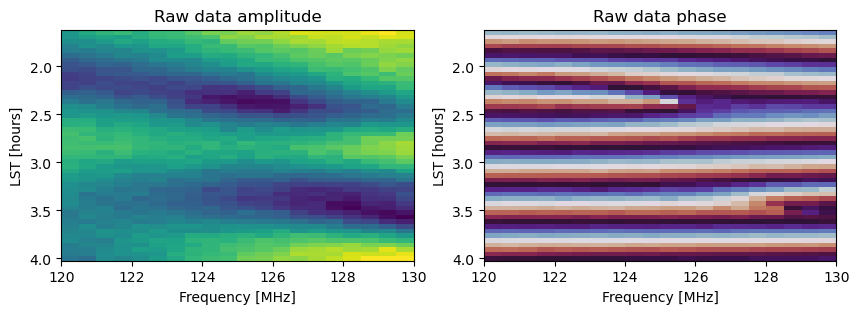

In [30]:
# plot a single visibility amplitude (left) and phase (right)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
bl = (0, 2)
extent = [freqs[0]/1e6, freqs[-1]/1e6, lsts[-1], lsts[0]]
axes[0].imshow(raw_vis[bl].abs(), aspect='auto', extent=extent)
axes[0].set_xlabel('Frequency [MHz]'); axes[0].set_ylabel('LST [hours]')
axes[0].set_title('Raw data amplitude')
axes[1].imshow(raw_vis[bl].angle(), aspect='auto', cmap='twilight', extent=extent)
axes[1].set_xlabel('Frequency [MHz]'); axes[1].set_ylabel('LST [hours]')
axes[1].set_title('Raw data phase');

Let's also look at the difference between the raw data and the starting visibility, which tells us how far we need to go in our optimization process.

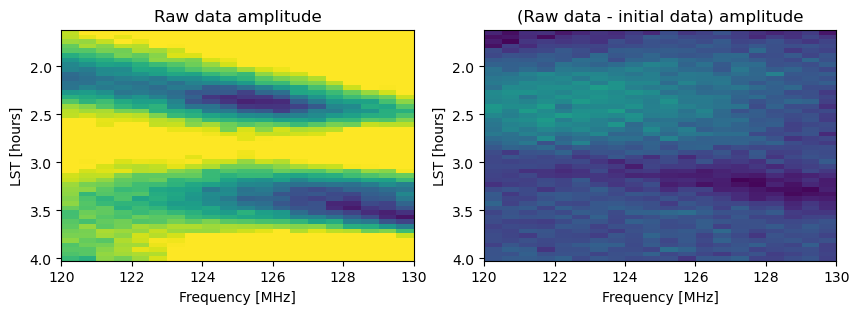

In [31]:
# plot a single visibility amplitude (left) and phase (right)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
bl = (0, 2)
extent = [freqs[0]/1e6, freqs[-1]/1e6, lsts[-1], lsts[0]]
axes[0].imshow(raw_vis[bl].abs(), aspect='auto', extent=extent, vmin=0, vmax=20)
axes[0].set_xlabel('Frequency [MHz]'); axes[0].set_ylabel('LST [hours]')
axes[0].set_title('Raw data amplitude')
axes[1].imshow((raw_vis-init_vis)[bl].abs(), aspect='auto', extent=extent, vmin=0, vmax=20)
axes[1].set_xlabel('Frequency [MHz]'); axes[1].set_ylabel('LST [hours]')
axes[1].set_title('(Raw data - initial data) amplitude');

We can see that the initial model is not a bad first guess, as it reduces some of the observed signal in the raw data; however, it certainly does not look noise like, meaning we have some progress to make in our optimization.

For LIM practitioners, we typically look at the data in Fourier space because this is where most of the information content comes from. There are easy-to-use tools for doing this on `VisData` objects in BayesLIM, as shown below. These tools will work on both data tensors and `VisData` objects automatically.

In [32]:
# make a Fourier transform operator for taking an FT across the frequncy dimension
FT = ba.fft.FFT(
    dim = -1,  # frequency axis of visibilities
    window = 'blackmanharris',  # frequency tapering function
    N = Nfreqs,
    ndim = 5,  # ndim of vis.data.shape
    dx = freqs[1] - freqs[0],  # this is for computing delay bins
    abs=True,  # this takes the abs after FT
)

In [33]:
# take the FFT of a VisData object, which returns a VisData copy with FFT data
# delay modes are stored as FT.freqs
raw_fft = FT(raw_vis)
init_fft = FT(init_vis)

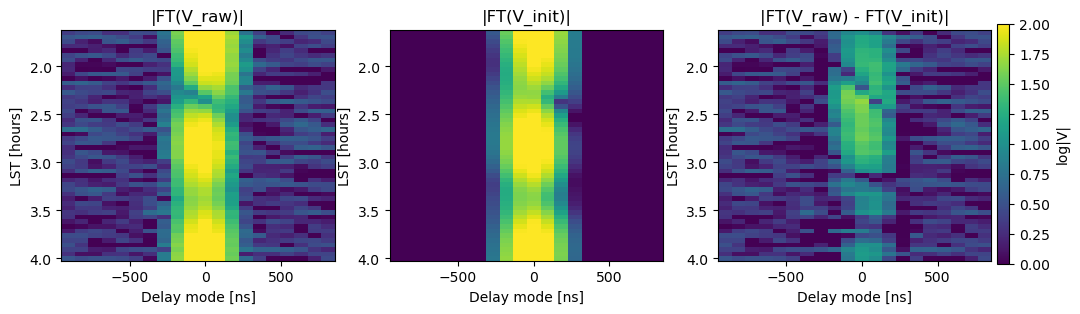

In [34]:
# plot the delay transformed visibility averaged across time
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
extent = [FT.freqs[0]*1e9, FT.freqs[-1]*1e9, lsts[-1], lsts[0]]
cax = axes[0].imshow(raw_fft[bl].log10(), aspect='auto', extent=extent, vmin=0, vmax=2)
axes[0].set_title("|FT(V_raw)|")
cax = axes[1].imshow(init_fft[bl].log10(), aspect='auto', extent=extent, vmin=0, vmax=2)
axes[1].set_title("|FT(V_init)|")
cax = axes[2].imshow((raw_fft-init_fft)[bl].abs().log10(), aspect='auto', extent=extent, vmin=0, vmax=2)
axes[2].set_title("|FT(V_raw) - FT(V_init)|")
cbax = fig.add_axes([.82, .1, .1, .8]); cbax.axis('off')
cbar = fig.colorbar(cax, ax=cbax, label=r'log|V|')
for ax in axes:
    ax.set_xlabel('Delay mode [ns]')
    ax.set_ylabel('LST [hours]');

Finally, to wrap up this section, let's attach the covariance to the data and create the log-posterior object.

In [35]:
# this attaches the covariance to the data and computes the inverse covariance
cov_axis = None  # this means it's a diagonal covariance
raw_vis.set_cov(torch.ones(raw_vis.data.shape) * N, cov_axis)
raw_vis.compute_icov()

In [36]:
# now let's create the log-posterior
target = ba.dataset.Dataset(raw_vis)

prob = ba.optim.LogProb(rime, target, compute='post')

print(prob)

LogProb(
  (model): RIME(
    (sky): PointSky()
    (beam): PixelBeam()
    (array): ArrayModel()
  )
)


## Running the Optimization

Now we'll select an optimizer, setup the training object, and run the optimization to the maximum a posteriori (MAP) location.

But first, we need to collect all the model parameters into a single place. This can be done by using the `prob.set_main_params()` method, which collects all the differentiable parameters and concatenates them into a single tensor, $\theta$, which we call `prob.main_params`. When evaluating the forward model via `prob()`, this single parameter tensor is then re-chunked and sent back to the individual model components, which are then evaluated per-usual.

This is particularly useful when, for example, we only want to optimize certain sub-selections of our parameter tensor, as we are doing here with the point sources, where we only want to optimize the flux amplitude, not the spectral index. Here's what this looks like:

In [37]:
# here we are picking out each of the tunable model parameters
# we care about, and choosing how to index them before unraveling
# and concatenating into prob.main_params
prob.set_main_params(model_params=[
    ('sky.params', (0, 0, 0), 'sky'),         # this picks out only log-fluxes of sky model
    ('beam.params', (slice(None),), 'beam'),  # this picks all elements of beam_model.params
])
print("prob.main_params.shape =", prob.main_params.shape)

prob.main_params.shape = torch.Size([1040])


To see how the parameters are chunked into `main_params`, inspect some of the associated metadata:

In [38]:
# this tells you how the parameters are sorted into prob.main_params
print(prob._main_indices)

{'sky': slice(0, 1000, None), 'beam': slice(1000, 1040, None)}


Next let's attach the log-posterior to a `Trainer` object that will track stats like the parameter values and the loss function as we optimize.

In [39]:
# now setup a trainer object to track stats
trainer = ba.optim.Trainer(prob, track=True)

Now let's select an optimizer, we can use any `torch.optim` optimizer, or also the `ba.bfgs.LBFGS()` optimizer. Note that LBFGS is a good out-of-the-box optimizer, and works well for highly correlated spaces as is often the case in real applications.

<div class="alert alert-block alert-info"><b>Note:</b>

L-BFGS is a good out-of-the-box optimizer for tricky parameter spaces, but only works well when the eigenspectrum of the Hessian is fairly flat. This means that different parameter tensors may need some amount of re-scaling relative to each other for the algorithm as a whole to work well. You can experiment with `ba.bfgs.lbfgs_approx_cov` to get an estimate of the best starting inverse Hessian (`H0`) to feed it. In other cases, the first gradient step might be so large that it puts the system in an irretrievable state (as is the case below). In this case, a small initial `H0` can help get the optimization going, as demonstrated below. All of these choices require a little manual experimentation, so keep this in mind.
</div> 

In [40]:
# choose a small starting inverse-Hessian to prevent catastrophic overshoot on the first gradient iteration.
H0 = ba.hmat.DiagMat(torch.tensor(1e-5), len(prob.main_params))

# Initialize the LBFGS optimizer
opt = ba.bfgs.LBFGS((prob.main_params,), H0=H0, max_iter=1, history_size=20)

In [41]:
# set the optimizer to trainer
trainer.set_opt(opt)

In [42]:
%%time
# you can re-run this cell and it will pick-up where it left off
trainer.train(Nepochs=400);

CPU times: user 4min 31s, sys: 3min 58s, total: 8min 29s
Wall time: 1min 16s


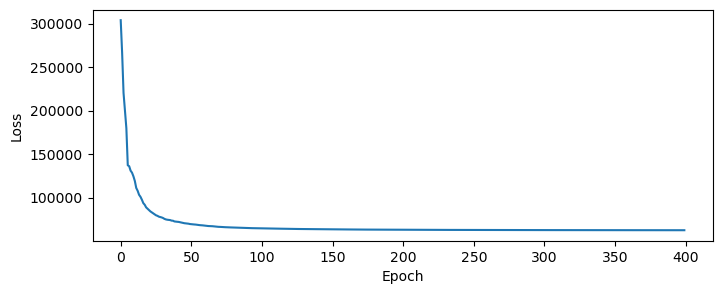

In [43]:
# now let's inspect the loss
plt.figure(figsize=(8, 3))
plt.plot(trainer.loss)
plt.xlabel('Epoch'); plt.ylabel('Loss');

Remember that the "loss" is actually the un-normalized log-posterior. Next let's inspect the beam optimization.

### Inspecting the results

In [44]:
# get final beam_params
end_beam_params = rime.beam.params.detach()

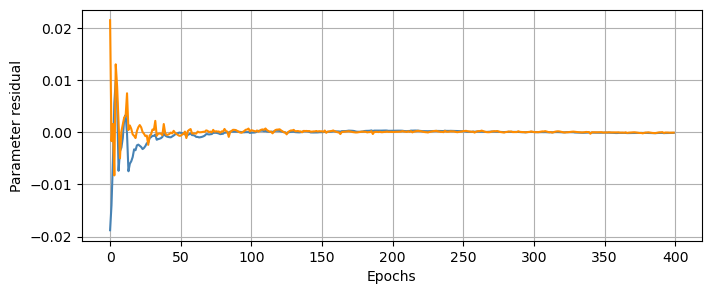

In [45]:
# plot the beam parameter convergence
plt.figure(figsize=(8, 3))
beam_chain = torch.stack(trainer.chain['model.beam.params'])
plt.plot(beam_chain[:,0,0,0,0,0] - true_beam[0,0,0,0,0], c='steelblue')  # ew
plt.plot(beam_chain[:,0,0,0,0,1] - true_beam[0,0,0,0,1], c='darkorange')  # ns
plt.xlabel('Epochs'); plt.ylabel('Parameter residual')
plt.grid();

We can also look at the sky model optimization.

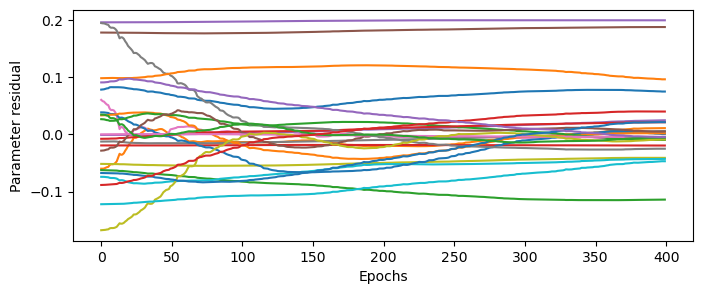

In [46]:
# plot the sky parameter convergence
plt.figure(figsize=(8, 3))
sky_chain = torch.stack(trainer.chain['model.sky.params'])
plt.plot(sky_chain[:,0,0,0,::40] - true_sky[0,0,0,::40]);
plt.xlabel('Epochs'); plt.ylabel('Parameter residual');

Notice that some sky sources are converging while others are not. This is because only some lie within the main lobe of the primary beam, and are thus sensitive to being optimized. For sources that lie far in the beam sidelobes, they are strongly attenuated and thus are not as sensitive to the loss function.

Let's plot them on the sky.

In [47]:
# get final parameters
end_sky_params = sky_model.params.detach()

Text(0.5, 1.0, 'Ending Error')

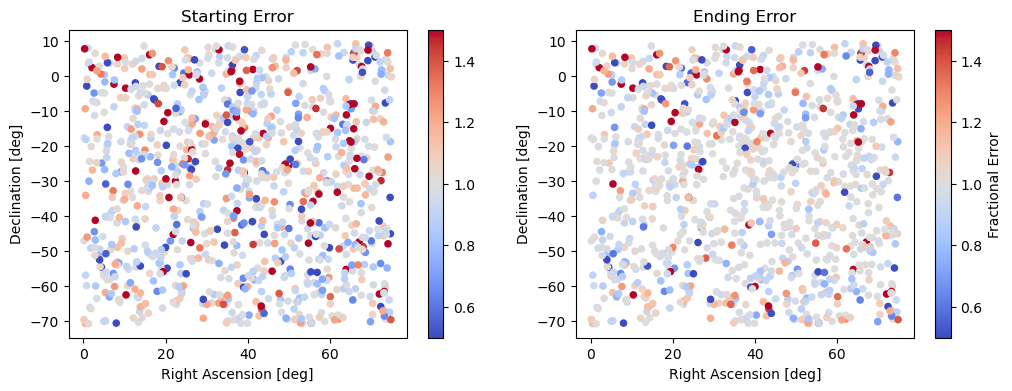

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# starting point
cax = axes[0].scatter(*sky_angs, c=sky_params[0,0,0] / true_sky[0,0,0], cmap='coolwarm', vmin=.5, vmax=1.5, s=20)
axes[0].set_xlabel('Right Ascension [deg]'); axes[0].set_ylabel('Declination [deg]')
fig.colorbar(cax, ax=axes[0]); axes[0].set_title('Starting Error')
# ending point
cax = axes[1].scatter(*sky_angs, c=end_sky_params[0,0,0] / true_sky[0,0,0], cmap='coolwarm', vmin=.5, vmax=1.5, s=20)
axes[1].set_xlabel('Right Ascension [deg]'); axes[1].set_ylabel('Declination [deg]')
fig.colorbar(cax, ax=axes[1], label='Fractional Error'); axes[1].set_title('Ending Error')

You'll notice a slight band near the pointing center (at -30 degrees declination) where the point source residuals tend to be closer to 1.0 then at other declinations. We can get a better picture of this by looking at the point source parameter residuals w.r.t. declination.

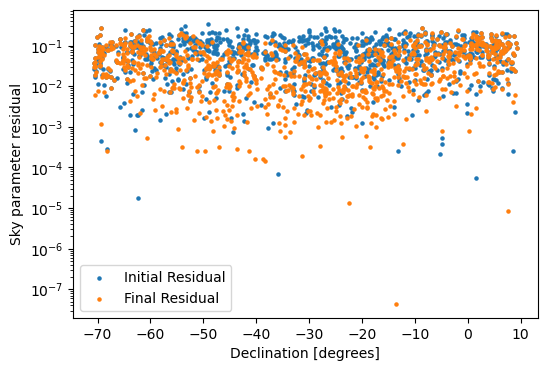

In [49]:
plt.figure(figsize=(6, 4))
plt.scatter(sky_model.angs[1], (true_sky - init_sky)[0,0,0].abs(), s=5, label='Initial Residual')
plt.scatter(sky_model.angs[1], (true_sky - end_sky_params)[0,0,0].abs(), s=5, label='Final Residual')
plt.yscale('log'); plt.legend()
plt.xlabel('Declination [degrees]'); plt.ylabel('Sky parameter residual');

We can also look at the residual visibilities to check if they are noise-like.

In [50]:
# get visibility after optimization
with torch.no_grad():
    end_vis = rime()

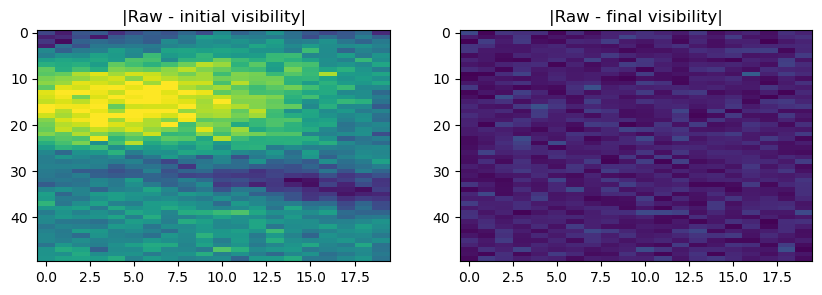

In [51]:
# plot a single visibility amplitude (left) and phase (right)
# plot a single visibility amplitude (left) and phase (right)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
bl = (0, 2)
axes[0].imshow((raw_vis-init_vis)[bl].abs(), aspect='auto', vmin=0, vmax=10)
axes[0].set_title("|Raw - initial visibility|")
axes[1].imshow((raw_vis - end_vis)[bl].abs(), aspect='auto', vmin=0, vmax=10)
axes[1].set_title("|Raw - final visibility|");

The residual visibility for a single baseline looks like noise, meaning we've been able to model the signal down to the noise floor. Note that this is just a heuristic, and in principle, due to the many baselines sampled, one can actually probe below the per-baseline noise floor with the model.

<div class="alert alert-block alert-warning"><b>Caution:</b>

Because we are optimizing a non-linear data model, one should be wary of using a reduced-chi square statistic for assessing consistency with noise and/or optimization convergence ([Andrae et al. 2010](https://arxiv.org/abs/1012.3754)). With a non-linear model it can be difficult to accurately estimate the model's degrees of freedom, and thus a properly normalized reduced chi-square is not well-defined. Nevertheless, one could still use it as a rough heuristic for the optimization, or to assess optimization progress relative to previous iterations.
</div> 

## Posterior Uncertainty Quantification

Now that we've optimized to the MAP, we'd like to explore the posterior to perform uncertainty quantification, i.e. compute credible contours and marginalized credible intervals. We can do this through a number of approaches, namely through Markov Chain Monte Carlo (MCMC) sampling, which BayesLIM is equipped to do with a Hamiltonian Monte Carlo approach. However, for the sake of this demonstration, we will simply use the Fisher matrix to compute a Gaussian approximation to the posterior, which will serve as a rough estimate of the uncertainty. This is also known as the Laplace approximation, which says that if we Taylor expand the (nonlinear) forward model as a linear model locally, then we can compute the covariance of the model by looking at its second-derivatives. The $N\times N$ matrix of second derivatives is known as the Hessian matrix, and its inverse gives us the posterior covariance.

We will only compute the Hessian matrix for a subset of the point sources, and for both beam parameters.
That means we will perform a new parameter selection, this time indexing along the Nsources axis of the sky model.

In [52]:
# get 100 random point sources from our sky catalogue
np.random.seed(1)
ps_idx = torch.as_tensor(np.random.choice(np.arange(1000), size=100, replace=False))
prob.set_main_params(model_params=[
    ('sky.params', (0, 0, 0, ps_idx), 'sky'),
    ('beam.params', (slice(None),), 'beam'),
])
print("Nparams :", prob.main_params.numel())

Nparams : 140


In [53]:
%%time
# compute the hessian matrix, note the model is already at the MAP point after our optimization
prob.compute = 'post'
hessian_output = ba.optim.compute_hessian(prob, 'main_params')

# returns as a list of dictionaries, unpack to get the hessinn
post_hess = hessian_output[0]['main_params']

CPU times: user 36.3 s, sys: 21.1 s, total: 57.5 s
Wall time: 13.7 s


In [54]:
%%time
# compute also compute the prior model, this is much faster b/c it doesn't require the forward model
prob.compute = 'prior'
hessian_output = ba.optim.compute_hessian(prob, 'main_params')

# returns as a list of dictionaries, unpack to get the hessinn
prior_hess = hessian_output[0]['main_params']

# set the compute back to posterior
prob.compute = 'post'

CPU times: user 11.9 ms, sys: 1.23 ms, total: 13.1 ms
Wall time: 12.4 ms


In [55]:
# invert this to get the covariance, note that by inverting the full matrix, we are performing marginalization
post_cov = torch.linalg.pinv(post_hess)
prior_cov = torch.linalg.pinv(prior_hess)

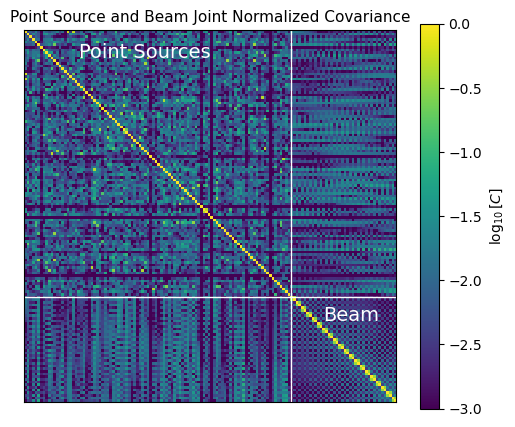

In [56]:
# look at the derived covariance matrix, normalized by the diagonal
C = post_cov.diag().pow(-.5).diag() @ post_cov @ post_cov.diag().pow(-.5).diag()
plt.figure(figsize=(6, 5))
plt.imshow(C.abs().log10(), vmin=-3, vmax=0, interpolation='none')
plt.xticks([]); plt.yticks([]);
plt.axvline(100, c='w', lw=1); plt.axhline(100, c='w', lw=1)
plt.text(20, 10, 'Point Sources', c='w', fontsize=14)
plt.text(112, 109, 'Beam', c='w', fontsize=14)
plt.title('Point Source and Beam Joint Normalized Covariance', fontsize=11)
plt.colorbar(label=r'$\log_{10}[C]$');

Above you are looking at the diagonally-normalized covariance. This is kind of like the correlation matrix, except we are still plotting variance and covariances. Normalizing by the diagonal allows us to assess the impact of off-diagonal elements, which we can see are fairly low at the $10^{-2}$ level. We can see, however, that neighboring elements in the beam component (indices > 200) share high covariance between each other.

Let's look at some marginalized posteriors for some parameters.

In [57]:
def plot_gauss(ax, mean, var, **kwargs):
    x = torch.linspace(mean-var.sqrt()*2.5, mean+var.sqrt()*2.5, 101)
    ax.plot(x, torch.exp(-.5 * (x-mean)**2 / var), **kwargs)

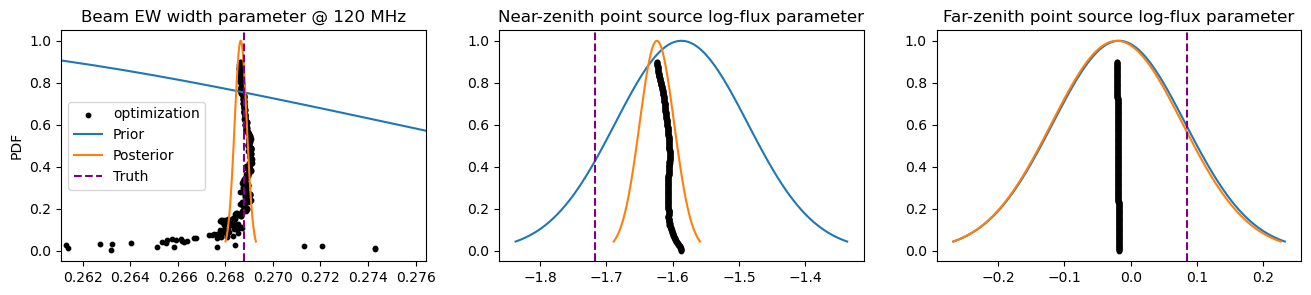

In [58]:
# make some 1v1 posterior plots
fig, axes = plt.subplots(1, 3, figsize=(16, 3))

# plot posterior for beam EW width at freqs[0]
ax = axes[0]
ax.scatter(beam_chain[:,0,0,0,0,0], np.linspace(0, .9, len(beam_chain)), s=10, c='k', label='optimization') # plot optimization
plot_gauss(ax, init_beam[0,0,0,0,0], prior_cov[100,100], label='Prior') # plot prior
plot_gauss(ax, end_beam_params[0,0,0,0,0], post_cov[100,100], label='Posterior') # plot prior
ax.axvline(true_beam[0,0,0,0,0], c='purple', ls='--', label='Truth')
ax.legend(); ax.set_title('Beam EW width parameter @ 120 MHz'); ax.set_ylabel('PDF')
ax.set_xlim(true_beam[0,0,0,0,0]-post_cov[100,100].sqrt()*30, true_beam[0,0,0,0,0]+post_cov[100,100].sqrt()*30)

# plot posterior for sky point source near zenith
ax = axes[1]
idx = (sky_model.angs[1, ps_idx] - -30.72).abs().argmin().item()  # index of source near zenith pointing
ax.scatter(sky_chain[:,0,0,0,ps_idx][:, idx], np.linspace(0, .9, len(sky_chain)), s=10, c='k', label='optimization') # plot optimization
plot_gauss(ax, init_sky[0,0,0,ps_idx][idx], prior_cov[idx,idx], label='Prior') # plot prior
plot_gauss(ax, end_sky_params[0,0,0,ps_idx][idx], post_cov[idx,idx], label='Posterior') # plot posterior
ax.axvline(true_sky[0,0,0,ps_idx][idx], c='purple', ls='--', label='Truth')
ax.set_title('Near-zenith point source log-flux parameter')

# plot posterior for sky point source near zenith
ax = axes[2]
idx = (sky_model.angs[1, ps_idx] - -30.72).abs().argmax().item()  # index of source far from zenith pointing
ax.scatter(sky_chain[:,0,0,0,ps_idx][:, idx], np.linspace(0, .9, len(sky_chain)), s=10, c='k', label='optimization') # plot optimization
plot_gauss(ax, init_sky[0,0,0,ps_idx][idx], prior_cov[idx,idx], label='Prior') # plot prior
plot_gauss(ax, end_sky_params[0,0,0,ps_idx][idx], post_cov[idx,idx], label='Posterior') # plot posterior
ax.axvline(true_sky[0,0,0,ps_idx][idx], c='purple', ls='--', label='Truth')
ax.set_title('Far-zenith point source log-flux parameter');

We can see that the model is most sensitive to the beam parameters, which have a very strong impact on the loss function due to the fact that the posterior is much more sharply peaked than the prior. The point sources near zenith also have some sway on the loss function, and as suspected, the point sources away from zenith have posterior widths effectively as wide as the prior.